In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [2]:
# Configurations
input_directory = r"C:\Users\33658\Documents\Celebrity Faces Cropped"  # Dataset cropped
image_size = (224, 224)  # Taille des images pour MobileNetV2
learning_rate = 0.0008
batch_size = 32


In [3]:

# Étape 1 : Préparer les données
datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normaliser les pixels
    validation_split=0.2,  # 20% pour la validation
    horizontal_flip=True,  # Augmenter les données
    zoom_range=0.2
)

train_generator = datagen.flow_from_directory(
    input_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

validation_generator = datagen.flow_from_directory(
    input_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

Found 601 images belonging to 9 classes.
Found 146 images belonging to 9 classes.


In [4]:
# Étape 2 : Construire le modèle
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(train_generator.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Geler les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

In [5]:
# Étape 3 : Compiler le modèle
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [6]:
from tensorflow.keras.callbacks import EarlyStopping

# Configurer Early Stopping
early_stopping = EarlyStopping(
    monitor="val_loss",  # Surveiller la perte sur l'ensemble de validation
    patience=25,          # Nombre d'époques sans amélioration avant d'arrêter
    restore_best_weights=True,  # Restaurer les poids correspondant à la meilleure époque
    verbose=1            # Afficher un message lorsque l'entraînement s'arrête
)


Epoch 1/125


C:\Users\33658\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2077 - loss: 2.2648 - val_accuracy: 0.5000 - val_loss: 1.5835
Epoch 2/125
 1/18 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.4375 - loss: 1.6818

C:\Users\33658\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4375 - loss: 1.6818 - val_accuracy: 0.4444 - val_loss: 1.4326
Epoch 3/125
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 650ms/step - accuracy: 0.5201 - loss: 1.4520 - val_accuracy: 0.6484 - val_loss: 1.1665
Epoch 4/125
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6250 - loss: 1.3977 - val_accuracy: 0.7222 - val_loss: 1.1949
Epoch 5/125
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5948 - loss: 1.1833 - val_accuracy: 0.6797 - val_loss: 0.9795
Epoch 6/125
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8438 - loss: 0.8474 - val_accuracy: 0.8889 - val_loss: 0.6680
Epoch 7/125
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 680ms/step - accuracy: 0.7453 - loss: 0.8978 - val_accuracy: 0.7969 - val_loss: 0.8407
Epoch 8/125
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7188 - loss: 0.8951 - val_accuracy: 0.8889 - val_loss: 0.6337
Epoch 9/125
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 712ms/step - accuracy: 0.7820 - loss: 0.7579 - val_accuracy: 0.8438 - 

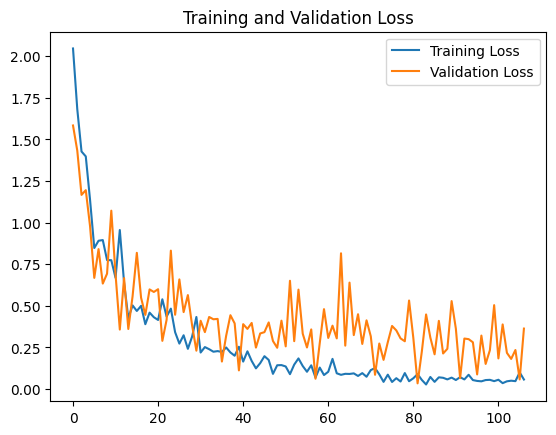

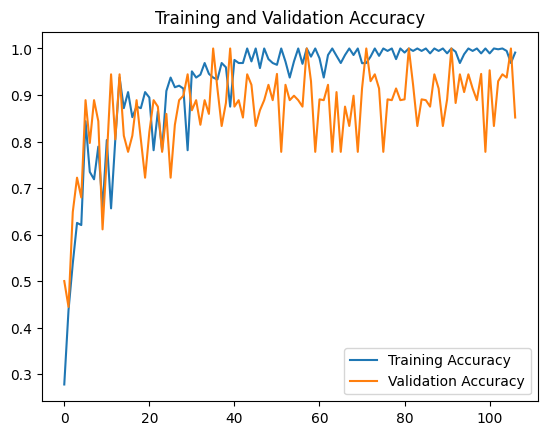

In [7]:
# Étape 4 : Entraîner le modèle
num_epochs = 125

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=num_epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]  # Ajouter le callback Early Stopping
)

import matplotlib.pyplot as plt

# Courbe de perte
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Courbe de précision (si surveillée)
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()


In [41]:
# Étape 5 : Sauvegarder le modèle
model.save("actor_recognition_model_update.h5")
model.save('actor_recognition_model_update.keras')
print("Modèle sauvegardé avec succès !")

Modèle sauvegardé avec succès !


Test du modele

In [29]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np

# Charger le modèle
model = load_model("actor_recognition_model_night.h5")

# Charger une image de test
img_path = "/content/drive/MyDrive/Colab Notebooks/Data/cruise_test2.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Prédiction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
print(f"L'acteur prédit est : {class_labels[predicted_class]}")


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\33658\\PycharmProjects\\Act-O-Matic\\Celebrity Faces Cropped\\Celebrity Faces Cropped\\Brad Pitt002_cc1b9701.jpg'

In [47]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Charger le modèle
model = load_model("actor_recognition_model_update.h5")

# Recompiler le modèle (si nécessaire)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Configurer les chemins
train_directory = r"C:\Users\33658\Documents\Celebrity Faces Cropped"  # Dossier utilisé pour l'entraînement
test_directory = r"C:\Users\33658\Documents\Celebrity Faces Cropped\Johnny Depp"  # Dossier de test
image_size = (224, 224)  # Taille d'entrée des images

# Récupérer les noms des classes depuis les sous-dossiers
datagen = ImageDataGenerator(rescale=1.0 / 255)
generator = datagen.flow_from_directory(
    train_directory,
    target_size=image_size,
    batch_size=32,
    class_mode="categorical"
)
class_labels = list(generator.class_indices.keys())  # Liste des noms de classes
print(f"Classes détectées : {class_labels}")

# Fonction pour prédire une image
def predict_image(image_path, model):
    # Charger et prétraiter l'image
    img = image.load_img(image_path, target_size=image_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Faire une prédiction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    confidence = predictions[0][predicted_class]

    return predicted_class, confidence

# Évaluer les performances globales
correct_predictions = 0
total_images = 0

# Parcourir les images du dossier et faire des prédictions
for img_name in os.listdir(test_directory):
    img_path = os.path.join(test_directory, img_name)

    # Vérifier que le fichier est une image
    if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
        predicted_class, confidence = predict_image(img_path, model)
        true_class = class_labels.index("Johnny Depp")  # Remplacer par la classe correcte pour ce dossier

        if predicted_class == true_class:
            correct_predictions += 1
        total_images += 1

        print(f"Image: {img_name} => Acteur prédit: {class_labels[predicted_class]} (Confiance: {confidence:.2f})")
    else:
        print(f"Fichier ignoré : {img_name}")

# Calculer et afficher la performance globale
accuracy = (correct_predictions / total_images) * 100 if total_images > 0 else 0
print(f"Total d'images évaluées : {total_images}")
print(f"Prédictions correctes : {correct_predictions}")
print(f"Précision globale : {accuracy:.2f}%")


Found 747 images belonging to 9 classes.
Classes détectées : ['Brad Pitt', 'Hugh Jackman', 'Johnny Depp', 'Leonardo DiCaprio', 'Natalie Portman', 'Robert Downey Jr', 'Tom Cruise', 'Tom Hanks', 'Will Smith']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
Image: 001_2288a4f6.jpg => Acteur prédit: Johnny Depp (Confiance: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image: 002_331d0423.jpg => Acteur prédit: Johnny Depp (Confiance: 0.66)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image: 003_64926b97.jpg => Acteur prédit: Johnny Depp (Confiance: 0.92)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image: 005_9406f32d.jpg => Acteur prédit: Johnny Depp (Confiance: 0.98)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Image: 006_8fc31fd7.jpg => Acteur prédit: Johnny Depp (Confiance: 0.99)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image: 007_1bc0bcd6.jpg => Acteur prédit: Johnny Depp (Confiance: 0.79)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image: 008_35d1be70.jpg => Acteur prédit: Johnny Depp (Confiance: 0.96)
1/1 ━━━━━━━━━━━━━━━━━━